# Data Preparation

In [1]:
TXT_SENTOKEN_DIR = 'review_polarity/txt_sentoken'

In [2]:
import string
import re
import os
from os import listdir
from nltk.corpus import stopwords

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text
    
def clean_doc(doc):
    tokens = doc.split()
    re_punc = re.compile('[{}]'.format(string.punctuation))
    # remove punctuation
    tokens = [re_punc.sub('',w) for w in tokens]
    # remove non-alpha
    tokens = [w for w in tokens if w.isalpha()]
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [w for w in tokens if len(w) > 1]
    return tokens
    
def doc_to_line(filename, vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

def process_doc(directory, vocab):
    lines = list()
    for f in listdir(directory):
#         print(f)
        if f.startswith('cv9'):
            continue
        path = os.path.join(directory, f)
        line = doc_to_line(path, vocab)
        lines.append(line)
    return lines

def load_clean_dataset(vocab):
    neg = process_doc(os.path.join(TXT_SENTOKEN_DIR, 'neg'), vocab)
    pos = process_doc(os.path.join(TXT_SENTOKEN_DIR, 'pos'), vocab)
    
    docs = neg + pos
    
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    
    return docs, labels
    

In [3]:
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [4]:
docs, labels = load_clean_dataset(vocab)

print(len(docs), len(labels))

1800 1800


# Bag-of-Words Vectors

In [5]:
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def process_docs(directory, vocab, is_train):
    lines = list()
    
    for fn in listdir(directory):
        if is_train and fn.startswith('cv9'):
            continue
        if not is_train and not fn.startswith('cv9'):
            continue
        path = os.path.join(directory, fn)
        line = doc_to_line(path, vocab)
        lines.append(line)
    return lines

def load_clean_dataset(vocab, is_train):
    neg = process_docs(os.path.join(TXT_SENTOKEN_DIR, 'neg'), vocab, is_train)
    pos = process_docs(os.path.join(TXT_SENTOKEN_DIR, 'pos'), vocab, is_train)
    
    docs = neg + pos
    
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

Using TensorFlow backend.
/Users/Thanakom/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)

tokenizer = create_tokenizer(train_docs)

x_train = tokenizer.texts_to_matrix(train_docs, mode='freq')
x_test = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(x_train.shape, x_test.shape)

(1800, 14781) (200, 14781)


## Sentiment Analysis Models

multilayer perceptron (MLP) models

### First sentiment analysis model


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

In [8]:
def define_model(n_words):
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [12]:
n_words = x_test.shape[1]

print(n_words)
model = define_model(n_words)

model.fit(x_train, ytrain, epochs=10, verbose=2)

loss, acc = model.evaluate(x_test, ytest, verbose=0)
print('Test Accuracy: {}'.format(acc*100))

14781
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                739100    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 739,151
Trainable params: 739,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 1s - loss: 0.6915 - acc: 0.5339
Epoch 2/10
 - 1s - loss: 0.6811 - acc: 0.7339
Epoch 3/10
 - 1s - loss: 0.6613 - acc: 0.8583
Epoch 4/10
 - 1s - loss: 0.6295 - acc: 0.8950
Epoch 5/10
 - 1s - loss: 0.5897 - acc: 0.8983
Epoch 6/10
 - 1s - loss: 0.5432 - acc: 0.9139
Epoch 7/10
 - 1s - loss: 0.4942 - acc: 0.9406
Epoch 8/10
 - 1s - loss: 0.4477 - acc: 0.9428
Epoch 9/10
 - 1s - loss: 0.4018 - acc: 0.9456
Epoch 10/10
 - 1s - loss: 0.3613 - acc: 0.9544
Test Accuracy: 87.0


### Comparing Word Scoring Methods

`texts_to_matrix()` has 4 methods:
- binary
- count
- tfidf
- freq

In [25]:
def prepare_data(train_docs, test_docs, mode):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_docs)
    
    x_train = tokenizer.texts_to_matrix(train_docs, mode=mode)
    x_test = tokenizer.texts_to_matrix(test_docs, mode=mode)
    
    return x_train, x_test

def evaluate_mode(x_train, y_train, x_test, y_test):
    scores = list()
    n_repeats = 10
    n_words = x_test.shape[1]
    
    for i in range(n_repeats):
        model = define_model(n_words)
        model.fit(x_train, y_train, epochs=10, verbose=0)
        _, acc = model.evaluate(x_test, y_test, verbose=0)
        
        scores.append(acc)
        print('{} accuracy: {}'.format((i+1), acc))
    return scores

In [26]:
import pandas as pd
modes = ['binary','count','tfidf','freq']

results = pd.DataFrame()

for mode in modes:
    x_train, x_test = prepare_data(train_docs, test_docs, mode)
    
    results[mode] = evaluate_mode(x_train, ytrain, x_test, ytest)
    
print(results.describe())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 50)                739100    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 739,151
Trainable params: 739,151
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.93
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 50)                739100    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 739,151
Trainable params: 739,151
Non-trainable params: 0
_________________________________________________________________
2 accuracy: 0.93
______________________________

4 accuracy: 0.905
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 50)                739100    
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 51        
Total params: 739,151
Trainable params: 739,151
Non-trainable params: 0
_________________________________________________________________
5 accuracy: 0.905
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 50)                739100    
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 51        
Total params: 739,151
Trainable params: 739,151
Non-trainable params: 0
_________________________________________________________________
6 accuracy: 0.895
__________

8 accuracy: 0.89
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 50)                739100    
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 51        
Total params: 739,151
Trainable params: 739,151
Non-trainable params: 0
_________________________________________________________________
9 accuracy: 0.9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 50)                739100    
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 51        
Total params: 739,151
Trainable params: 739,151
Non-trainable params: 0
_________________________________________________________________
10 accuracy: 0.895
____________

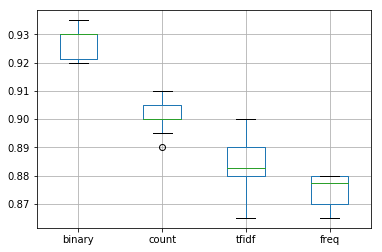

In [27]:
from matplotlib import pyplot
results.boxplot()
pyplot.show()

### Predicting Sentiment for New Reviews

In [29]:
def predict_sentiment(review, vocab, tokenizer, model):
    tokens = clean_doc(review)
    
    tokens = [w for w in tokens if w in vocab]
    
    line = ' '.join(tokens)
    
    encoded = tokenizer.texts_to_matrix([line], mode='binary')
    
    yhat = model.predict(encoded, verbose=0)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [34]:
x_train, x_test = prepare_data(train_docs, test_docs, 'binary')
n_words = x_test.shape[1]

model = define_model(n_words)

model.fit(x_train, ytrain, epochs=10, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 50)                739100    
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 51        
Total params: 739,151
Trainable params: 739,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 2s - loss: 0.4794 - acc: 0.7711
Epoch 2/10
 - 1s - loss: 0.0775 - acc: 0.9894
Epoch 3/10
 - 1s - loss: 0.0192 - acc: 1.0000
Epoch 4/10
 - 1s - loss: 0.0083 - acc: 1.0000
Epoch 5/10
 - 1s - loss: 0.0045 - acc: 1.0000
Epoch 6/10
 - 1s - loss: 0.0028 - acc: 1.0000
Epoch 7/10
 - 1s - loss: 0.0019 - acc: 1.0000
Epoch 8/10
 - 1s - loss: 0.0013 - acc: 1.0000
Epoch 9/10
 - 1s - loss: 9.9790e-04 - acc: 1.0000
Epoch 10/10
 - 1s - loss: 7.8120e-04 - acc: 1.0000


In [35]:
text = "Best movie ever! It was great. I recommend it."
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: {}\nSentiment: {} {}'.format(text,sentiment,percent*100))

Review: Best movie ever! It was great. I recommend it.
Sentiment: POSITIVE 60.12917757034302


In [36]:
text = "This is a bad movie."
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: {}\nSentiment: {} {}'.format(text,sentiment,percent*100))

Review: This is a bad movie.
Sentiment: NEGATIVE 66.4298564195633
